# ML Nanodegree Capstone: NBA Fantasy Prediction

## Introduction to Problem
In the US, the National Basketball Association (NBA), is one of the four major sports. There are many stats recorded in a basketball game, both offensive an defensive. Further, many other metrics can be computed from the recorded stats. For instance, points are recorded as well as minutes played, so we can investigate points per minute.

Additionally, fantasy sports, and more specifically, daily fantasy sports have become very popular as of late. In daily fantasy sports, a user selects about 8 basketball players that are playing that night. As many as hundreds of thousands of users pick a team on any given night. The entry fee to this daily tournament can range from 1 dollar to 100 dollars. Each player is rewarded a fantasy point value for stats recorded and the user that achieves the most fantasy points wins. In some tournaments, the users with the top 10% highest scores win some cash back.

Therefore, if I can predict how many fantasy points a player will score on a given night, it can be very lucrative, which is a regression problem. However, this prediction needs to be better than simple strategies such as the average fantasy points for each player. Another test could examine if a player will surpass his average for the season on a given night, this would be a classifier problem.

## How to go about Problem
The website basketball-reference.com has historical data for every NBA player going back for decades. For this project, I have downloaded the plast 3 years of gamelog data for each player. I downloaded full seasons 2013-14, 2014-15 and 2015-16, which comprise of 82 potential games for each player (sometimes there are injuries) and about 480 active players in the season. Therefore, there are about 82 x 480 = 39,360 potential gamelogs per season. However, given that there are injuries the number of actual gamelogs will be lower. Further, many players don't actually play in a given night or play very infrequently. These players are likely not important as they won't be selected in leagues. Therefore, for 3 seasons, my guess is that there are about 10,000 gamelogs per season that would be interesting to investigate.

Given this dataset, I would like to predict how many fantasy points a player achieves on a given night or if they surpass their season average, for games played in the 2016-17 season, which is the current season. The current season is only halfway complete to date. I have downloaded data through 26-Jan-2017, about 40 games. Therefore, I will train my models based on previous seasons and test the model on the current season.


In [4]:
#load the data
import numpy as np
import pandas as pd
import visuals as vs
from datetime import datetime
import matplotlib.pyplot as plt
date_format="%Y-%m-%d %H:%M:%S"
date_format2="%Y-%m-%d"

%matplotlib inline

data_14_15=pd.read_csv('nba_14_15.csv')
data_16_17=pd.read_csv('nba_16_17.csv')

//anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
//anaconda/lib/python2.7/site-packages/sklearn/learning_curve.py:23: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


In [5]:
full_data=pd.concat([data_14_15, data_16_17])

In [6]:
len(full_data)

73965

In [7]:
full_data.head()

,player,game_date,age,player_team,location,opp_team,result,gs,mp,fg,...,ast,stl,blk,tov,pf,pts,game_score,plus_minus,fantasy,year_end
0,Quincy Acy,2014-10-29 00:00:00,24-023,NYK,H,CHI,L (-24),0,21:28,3,...,1,0,1,2,4,6,3.4,-15,16.00,2015
1,Quincy Acy,2014-10-30 00:00:00,24-024,NYK,A,CLE,W (+5),1,22:27,4,...,2,0,1,2,6,8,7.8,2,24.50,2015
2,Quincy Acy,2014-11-02 00:00:00,24-027,NYK,H,CHO,W (+3),1,20:20,1,...,2,0,0,0,2,2,1.1,11,8.75,2015
3,Quincy Acy,2014-11-05 00:00:00,24-030,NYK,A,DET,L (-3),0,13:42,0,...,1,0,1,2,1,0,0.9,-6,10.00,2015
4,Quincy Acy,2014-11-07 00:00:00,24-032,NYK,A,BRK,L (-11),0,22:14,3,...,0,0,0,3,3,7,3.8,-15,16.75,2015


In [8]:
#Need to convert the mp from string to int (lose the seconds but that is ok)
if full_data['mp'].dtype=='object':
    full_data['mp']=full_data['mp'].str.split(":").str.get(0).astype(np.int64)
    print('conversion from string to int complete')
else:
    print('mp is not string')

conversion from string to int complete


## Data Exploration

In [9]:
print("the minimum year is: " + str(min(full_data['year_end'])))
print("the maximum year is: " + str(max(full_data['year_end'])))
print("the first game is: "+ str(min(full_data['game_date'])))
print("the last game is: "+ str(max(full_data['game_date'])))
print("the max number of minutes is: " + str(max(full_data['mp'])))
print("the min number of minutes is: " + str(min(full_data['mp'])))

the minimum year is: 2014
the maximum year is: 2017
the first game is: 2013-10-29 00:00:00
the last game is: 2017-01-27 00:00:00
the max number of minutes is: 60
the min number of minutes is: 0


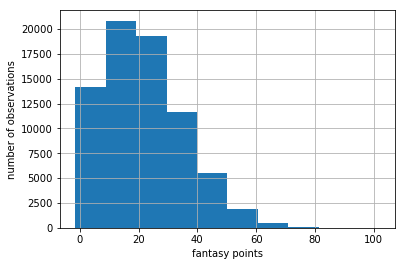

In [10]:
hist1=full_data['fantasy'].hist()
hist1.set_xlabel("fantasy points")
hist1.set_ylabel("number of observations")

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in power
  if __name__ == '__main__':


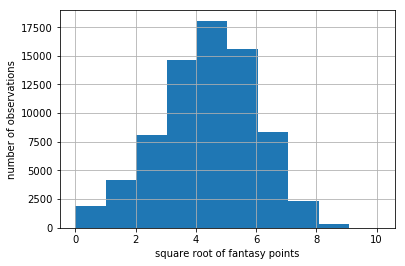

In [11]:
hist2=np.power(full_data['fantasy'],0.5).hist()
hist2.set_xlabel("square root of fantasy points")
hist2.set_ylabel("number of observations")

## Given the improved distribution (more normal) let's transform the y-variable

In [12]:
full_data['fantasy_trans']=np.power(full_data['fantasy'],0.5)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in power
  if __name__ == '__main__':


## Let's check the players with the highest fantasy points per game, who are the important players?

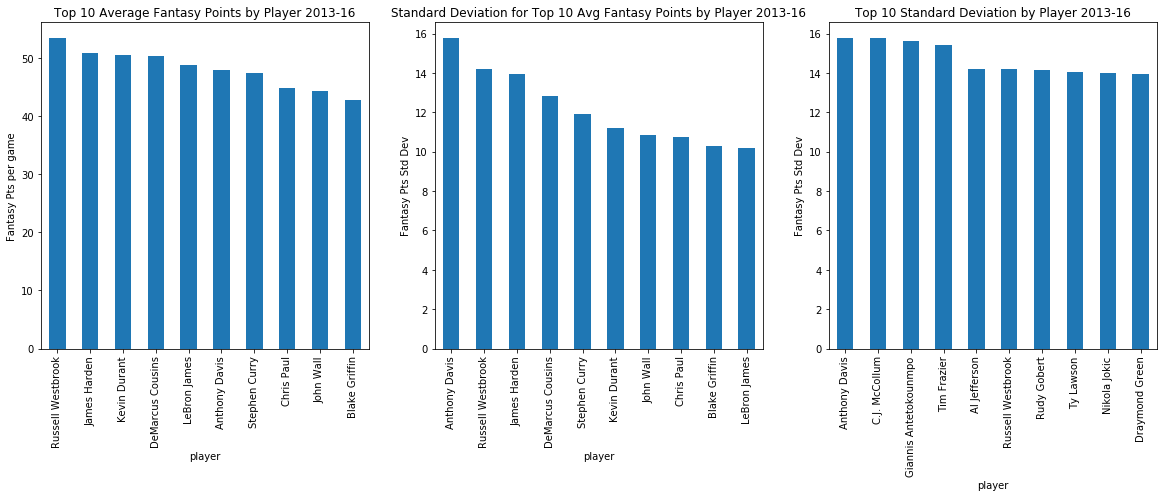

In [13]:
fig, axs = plt.subplots(1,3, figsize=(20,6))
afp=full_data.groupby('player')['fantasy'].mean().sort_values(ascending=False)[0:10].plot(ax=axs[0], kind='bar', title='Top 10 Average Fantasy Points by Player 2013-16')
afp.set_ylabel('Fantasy Pts per game')
std=full_data.groupby('player')['fantasy'].std().sort_values(ascending=False)[0:10].plot(ax=axs[2], kind='bar', title='Top 10 Standard Deviation by Player 2013-16')
std.set_ylabel('Fantasy Pts Std Dev')
top_10=full_data[(full_data['player']=='Russell Westbrook') | 
                 (full_data['player']=='James Harden') | 
                 (full_data['player']=='Kevin Durant') | 
                 (full_data['player']=='LeBron James') | 
                 (full_data['player']=='DeMarcus Cousins') | 
                 (full_data['player']=='Anthony Davis') | 
                 (full_data['player']=='Stephen Curry') | 
                 (full_data['player']=='John Wall') |
                 (full_data['player']=='Blake Griffin') | 
                 (full_data['player']=='Chris Paul')]
std2=top_10.groupby('player')['fantasy'].std().sort_values(ascending=False)[0:10].plot(ax=axs[1], kind='bar', title='Standard Deviation for Top 10 Avg Fantasy Points by Player 2013-16')
std2.set_ylabel('Fantasy Pts Std Dev')

In [14]:
full_data.groupby('player')['fantasy'].mean().sort_values(ascending=False)[0:10]

player
Russell Westbrook    53.459916
James Harden         50.806537
Kevin Durant         50.541111
DeMarcus Cousins     50.348958
LeBron James         48.753802
Anthony Davis        47.933544
Stephen Curry        47.452847
Chris Paul           44.877470
John Wall            44.252679
Blake Griffin        42.781250
Name: fantasy, dtype: float64

In [15]:
top_10.groupby('player')['fantasy'].std().sort_values(ascending=False)[0:10]

player
Anthony Davis        15.776715
Russell Westbrook    14.191747
James Harden         13.952915
DeMarcus Cousins     12.828012
Stephen Curry        11.900602
Kevin Durant         11.212399
John Wall            10.826083
Chris Paul           10.746045
Blake Griffin        10.300801
LeBron James         10.171759
Name: fantasy, dtype: float64

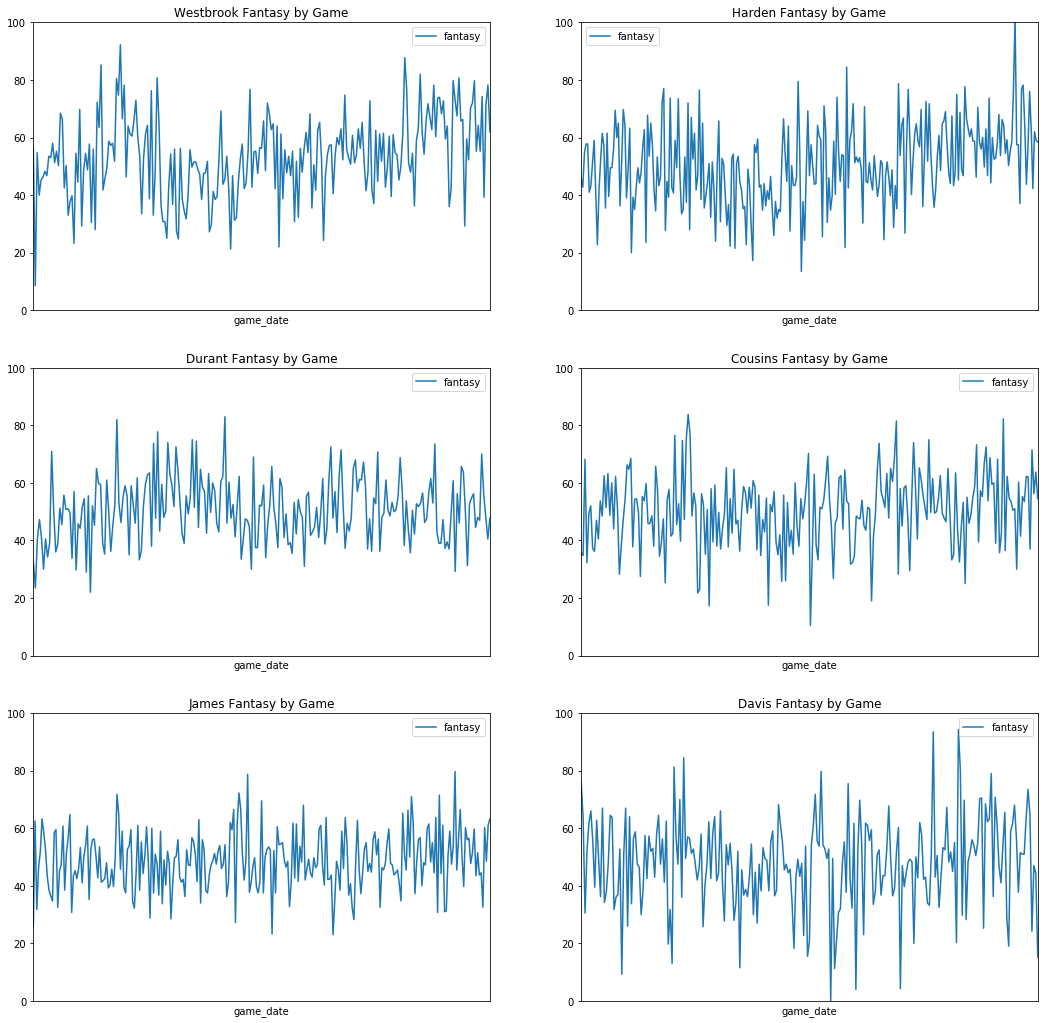

In [16]:
fig, axs = plt.subplots(3,2, figsize=(18,18))
rw=full_data[full_data['player']=='Russell Westbrook'][['game_date','fantasy']].plot(ax=axs[0,0], kind='line',x='game_date', y='fantasy', ylim=(0,100), xticks=[], title='Westbrook Fantasy by Game')
jh=full_data[full_data['player']=='James Harden'][['game_date','fantasy']].plot(ax=axs[0,1], kind='line',x='game_date', y='fantasy', ylim=(0,100), xticks=[], title='Harden Fantasy by Game')
kd=full_data[full_data['player']=='Kevin Durant'][['game_date','fantasy']].plot(ax=axs[1,0], kind='line',x='game_date', y='fantasy', ylim=(0,100), xticks=[], title='Durant Fantasy by Game')
dc=full_data[full_data['player']=='DeMarcus Cousins'][['game_date','fantasy']].plot(ax=axs[1,1], kind='line',x='game_date', y='fantasy', ylim=(0,100), xticks=[], title='Cousins Fantasy by Game')
lj=full_data[full_data['player']=='LeBron James'][['game_date','fantasy']].plot(ax=axs[2,0], kind='line',x='game_date', y='fantasy', ylim=(0,100), xticks=[], title='James Fantasy by Game')
ad=full_data[full_data['player']=='Anthony Davis'][['game_date','fantasy']].plot(ax=axs[2,1], kind='line',x='game_date', y='fantasy', ylim=(0,100), xticks=[], title='Davis Fantasy by Game')


## Examine the averages of the stats

In [17]:
print("Pts/game average for all players: " + str(float(sum(full_data['pts']))/float(len(full_data['pts']))))
print("Reb/game average for all players: " + str(float(sum(full_data['trb']))/float(len(full_data['trb']))))
print("Ast/game average for all players: " + str(float(sum(full_data['ast']))/float(len(full_data['ast']))))
print("Stl/game average for all players: " + str(float(sum(full_data['stl']))/float(len(full_data['stl']))))
print("Blk/game average for all players: " + str(float(sum(full_data['blk']))/float(len(full_data['blk']))))

Pts/game average for all players: 10.5134861083
Reb/game average for all players: 4.37402825661
Ast/game average for all players: 2.25944703576
Stl/game average for all players: 0.782221320895
Blk/game average for all players: 0.489326032583


## Split the data into training and testing

In [18]:
train_data=full_data[full_data['year_end']<2017]
test_data=full_data[full_data['year_end']==2017]

In [19]:
sort_train=train_data.sort_values(by=['player','game_date'], axis=0, ascending=True)
sort_test=test_data.sort_values(by=['player','game_date'], axis=0, ascending=True)

## Adding the rolling data

Adding a rolling mean for the past 10 games and past 3 games to see if this data informs us of how well a player will play tonight.

In [20]:
def add_avg(dataset, stat, roll):
    dataset['avg'+str(roll)+stat]=dataset.groupby('player')[stat].rolling(window=roll).mean().shift(1).values

In [21]:
def add_opp(dataset, stat, roll):
    dataset['avg '+str(roll)+stat]=dataset.groupby('opp_team')[stat].rolling(window=roll).mean().shift(1).values

In [22]:
unique_players=full_data.player.unique()
unique_teams=full_data.opp_team.unique()

In [23]:
new_df=pd.DataFrame()
for i in range(0,len(unique_players)):
    player_df=sort_train[sort_train['player']==unique_players[i]]
    add_avg(player_df, "pts",10)
    add_avg(player_df, "fantasy",10)
    add_avg(player_df, "plus_minus",10)
    add_avg(player_df, "ast",10)
    add_avg(player_df, "trb",10)
    add_avg(player_df, "stl",10)
    add_avg(player_df, "blk",10)
    add_avg(player_df, "fga",10)
    add_avg(player_df, "p3p",10)
    add_avg(player_df, "mp",10)
    add_avg(player_df, "pts",3)
    add_avg(player_df, "fantasy",3)
    add_avg(player_df, "plus_minus",3)
    add_avg(player_df, "ast",3)
    add_avg(player_df, "trb",3)
    add_avg(player_df, "stl",3)
    add_avg(player_df, "blk",3)
    add_avg(player_df, "fga",3)
    add_avg(player_df, "p3p",3)
    add_avg(player_df, "mp",3)
    player_df['rest_days']=pd.to_datetime(player_df['game_date'],format=date_format).values-pd.to_datetime(player_df['game_date'],format=date_format).shift(1).values
    player_df['rest']=(player_df['rest_days'].dt.total_seconds() / (24 * 60 * 60)).values
    player_df.loc[player_df['rest']>5,'rest']=5
    new_df=new_df.append(player_df)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/st

## Create data for the opposition fantasy

In [24]:
opp_data=pd.DataFrame({'opp_sum_fantasy':sort_train.groupby(['opp_team','game_date'])['fantasy'].sum()}).reset_index()

In [25]:
teams_df=pd.DataFrame()
for i in range(0,len(unique_teams)):
    team_df=opp_data[opp_data['opp_team']==unique_teams[i]]
    add_opp(team_df,'opp_sum_fantasy',10)
    teams_df=teams_df.append(team_df)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [26]:
final_data=pd.merge(new_df, teams_df, on=['opp_team', 'game_date'], how='left')

## Examine the distributions of the features, do they need to be transformed? 

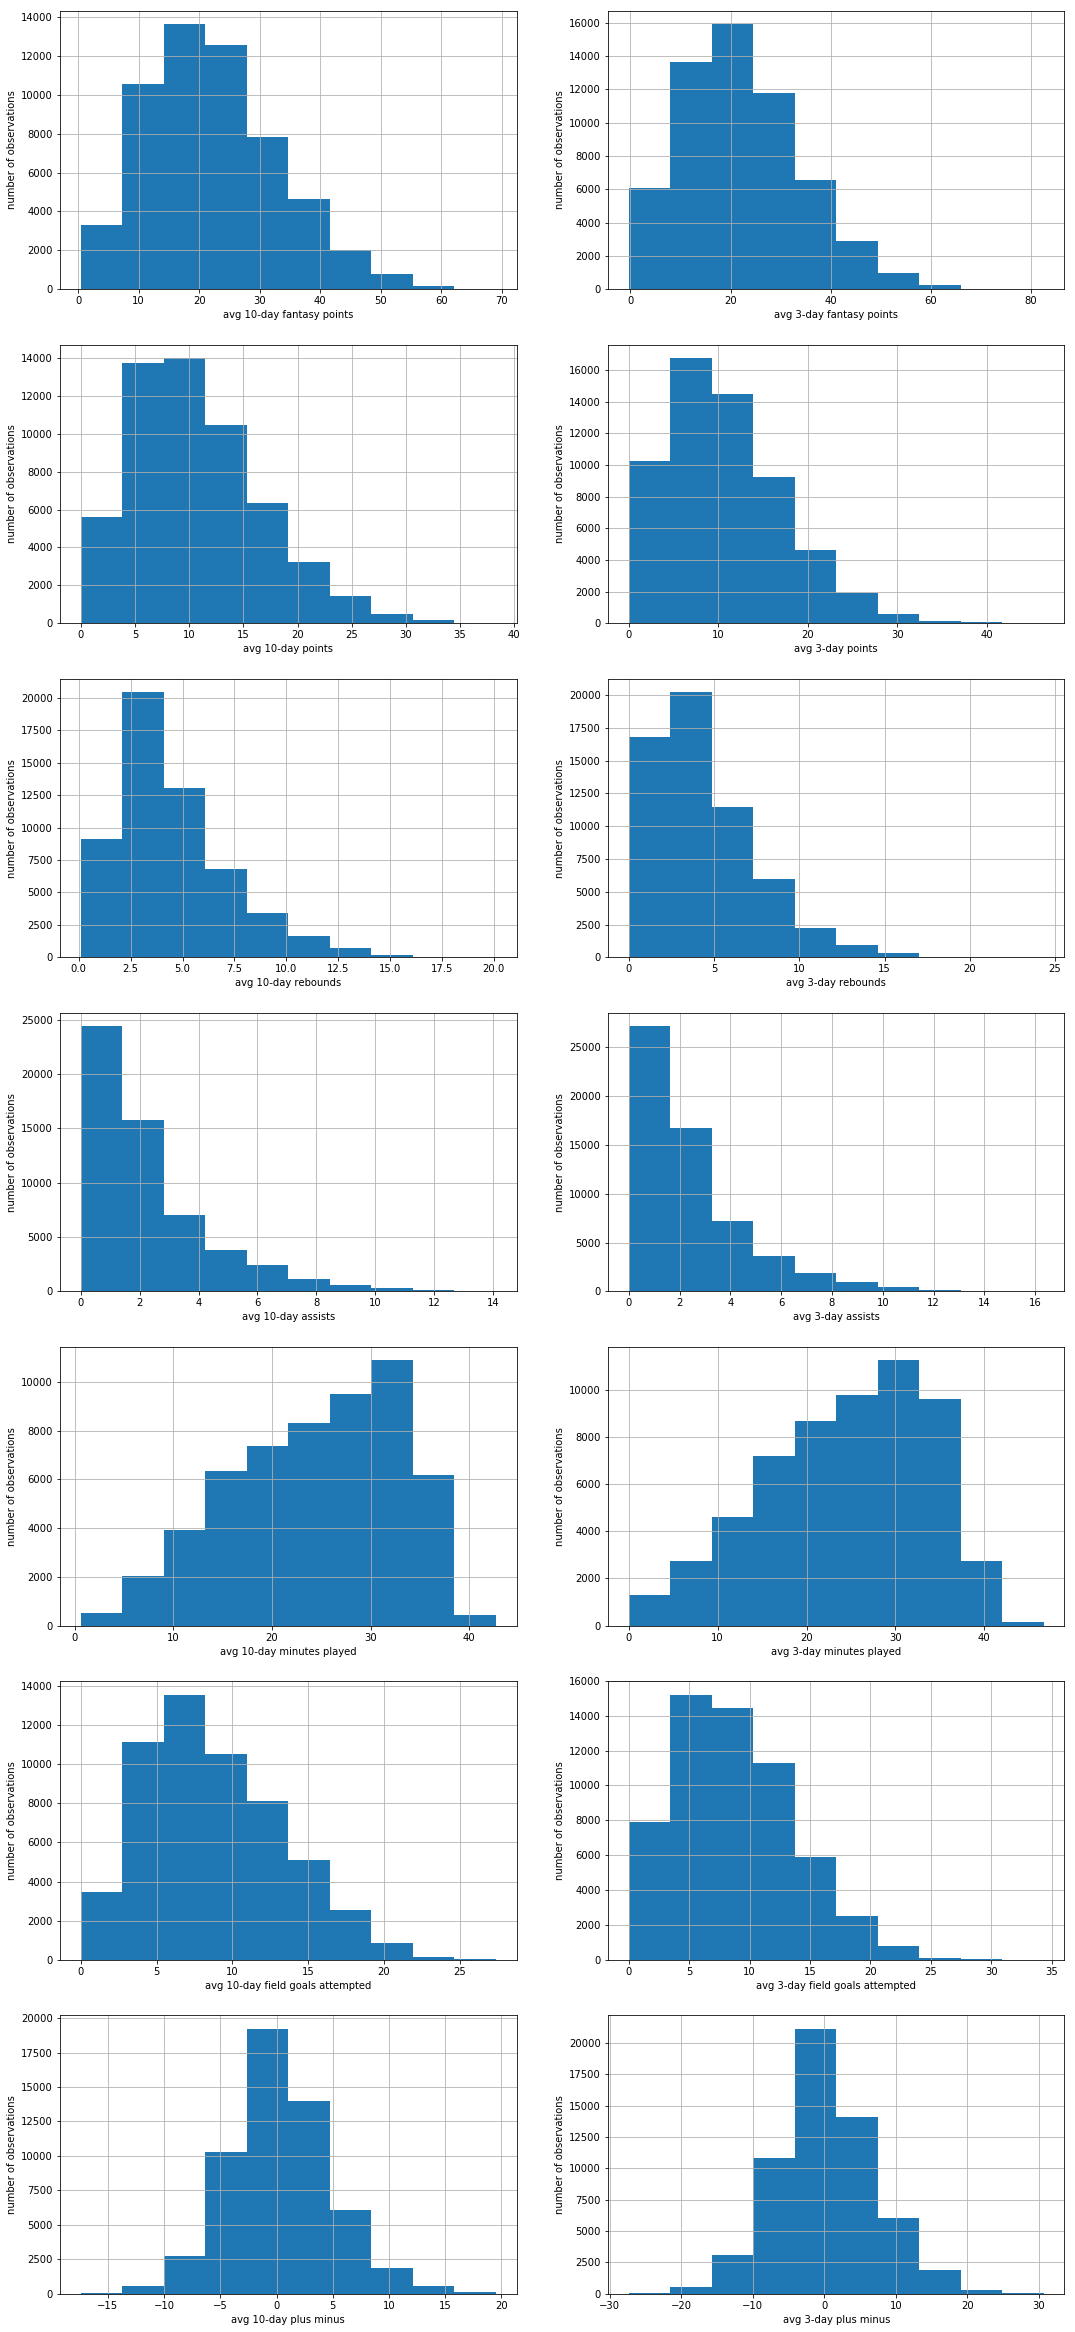

In [27]:
fig, axs = plt.subplots(7,2, figsize=(18,42))
fantasy10=final_data['avg10fantasy'].hist(ax=axs[0,0])
fantasy10.set_xlabel("avg 10-day fantasy points")
fantasy10.set_ylabel("number of observations")

fantasy3=final_data['avg3fantasy'].hist(ax=axs[0,1])
fantasy3.set_xlabel("avg 3-day fantasy points")
fantasy3.set_ylabel("number of observations")

pts10=final_data['avg10pts'].hist(ax=axs[1,0])
pts10.set_xlabel("avg 10-day points")
pts10.set_ylabel("number of observations")

pts3=final_data['avg3pts'].hist(ax=axs[1,1])
pts3.set_xlabel("avg 3-day points")
pts3.set_ylabel("number of observations")

trb10=final_data['avg10trb'].hist(ax=axs[2,0])
trb10.set_xlabel("avg 10-day rebounds")
trb10.set_ylabel("number of observations")

trb3=final_data['avg3trb'].hist(ax=axs[2,1])
trb3.set_xlabel("avg 3-day rebounds")
trb3.set_ylabel("number of observations")

ast10=final_data['avg10ast'].hist(ax=axs[3,0])
ast10.set_xlabel("avg 10-day assists")
ast10.set_ylabel("number of observations")

ast3=final_data['avg3ast'].hist(ax=axs[3,1])
ast3.set_xlabel("avg 3-day assists")
ast3.set_ylabel("number of observations")

mp10=final_data['avg10mp'].hist(ax=axs[4,0])
mp10.set_xlabel("avg 10-day minutes played")
mp10.set_ylabel("number of observations")

mp3=final_data['avg3mp'].hist(ax=axs[4,1])
mp3.set_xlabel("avg 3-day minutes played")
mp3.set_ylabel("number of observations")

fga10=final_data['avg10fga'].hist(ax=axs[5,0])
fga10.set_xlabel("avg 10-day field goals attempted")
fga10.set_ylabel("number of observations")

fga3=final_data['avg3fga'].hist(ax=axs[5,1])
fga3.set_xlabel("avg 3-day field goals attempted")
fga3.set_ylabel("number of observations")

plmin10=final_data['avg10plus_minus'].hist(ax=axs[6,0])
plmin10.set_xlabel("avg 10-day plus minus")
plmin10.set_ylabel("number of observations")

plmin3=final_data['avg3plus_minus'].hist(ax=axs[6,1])
plmin3.set_xlabel("avg 3-day plus minus")
plmin3.set_ylabel("number of observations")

## Yes, let's transform fantasy, points, rebounds and assists and look at the distributions

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in power


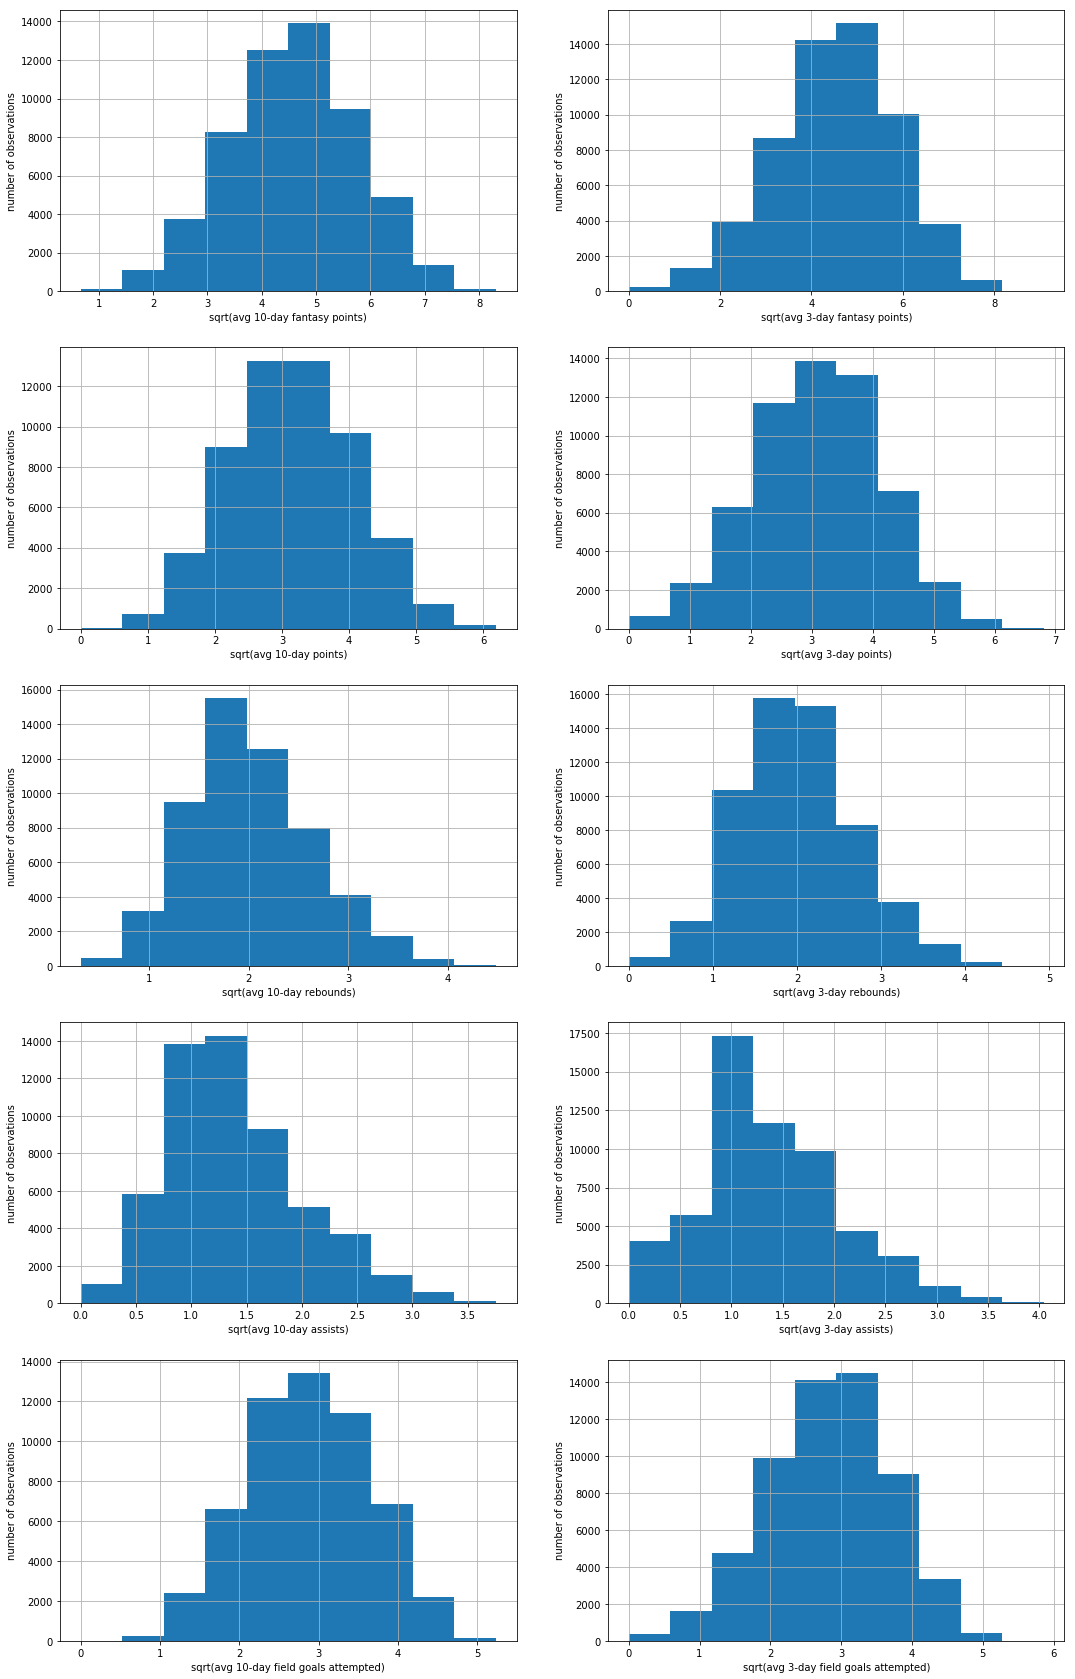

In [28]:
fig, axs = plt.subplots(5,2, figsize=(18,30))
fantasy10_2=np.power(final_data['avg10fantasy'],0.5).hist(ax=axs[0,0])
fantasy10_2.set_xlabel("sqrt(avg 10-day fantasy points)")
fantasy10_2.set_ylabel("number of observations")

fantasy3_2=np.power(final_data['avg3fantasy'],0.5).hist(ax=axs[0,1])
fantasy3_2.set_xlabel("sqrt(avg 3-day fantasy points)")
fantasy3_2.set_ylabel("number of observations")

pts10_2=np.power(final_data['avg10pts'],0.5).hist(ax=axs[1,0])
pts10_2.set_xlabel("sqrt(avg 10-day points)")
pts10_2.set_ylabel("number of observations")

pts3_2=np.power(final_data['avg3pts'],0.5).hist(ax=axs[1,1])
pts3_2.set_xlabel("sqrt(avg 3-day points)")
pts3_2.set_ylabel("number of observations")

trb10_2=np.power(final_data['avg10trb'],0.5).hist(ax=axs[2,0])
trb10_2.set_xlabel("sqrt(avg 10-day rebounds)")
trb10_2.set_ylabel("number of observations")

trb3_2=np.power(final_data['avg3trb'],0.5).hist(ax=axs[2,1])
trb3_2.set_xlabel("sqrt(avg 3-day rebounds)")
trb3_2.set_ylabel("number of observations")

ast10_2=np.power(final_data['avg10ast'],0.5).hist(ax=axs[3,0])
ast10_2.set_xlabel("sqrt(avg 10-day assists)")
ast10_2.set_ylabel("number of observations")

ast3_2=np.power(final_data['avg3ast'],0.5).hist(ax=axs[3,1])
ast3_2.set_xlabel("sqrt(avg 3-day assists)")
ast3_2.set_ylabel("number of observations")

fga10_2=np.power(final_data['avg10fga'],0.5).hist(ax=axs[4,0])
fga10_2.set_xlabel("sqrt(avg 10-day field goals attempted)")
fga10_2.set_ylabel("number of observations")

fga3_2=np.power(final_data['avg3fga'],0.5).hist(ax=axs[4,1])
fga3_2.set_xlabel("sqrt(avg 3-day field goals attempted)")
fga3_2.set_ylabel("number of observations")

## Remove the stats and transform features


Now I will remove the stats from the game and just concentrate on the rolling averages going into the game, the game location and the fantasy points scored in the game.

In [29]:
#drop the stats that I don't need
features = final_data.drop(['player','game_date','age','player_team','opp_team','result',
                            'gs','mp','fg','fga','fgp','ft','fta','ftp','ast','orb','drb','trb',
                            'stl','blk','p3','p3a','p3p','pts','plus_minus',
                            'game_score','year_end','tov','pf','opp_sum_fantasy', 'rest_days'], axis=1)

#remove the NA's
features_clean_notrans = features.dropna()

#transform the features into normal distributions
features['avg10fantasy_trans']=np.power(features['avg10fantasy'],0.5)
features['avg3fantasy_trans']=np.power(features['avg3fantasy'],0.5)
features['avg10pts_trans']=np.power(features['avg10pts'],0.5)
features['avg3pts_trans']=np.power(features['avg3pts'],0.5)
features['avg10trb_trans']=np.power(features['avg10trb'],0.5)
features['avg3trb_trans']=np.power(features['avg3trb'],0.5)
features['avg10ast_trans']=np.power(features['avg10ast'],0.5)
features['avg3ast_trans']=np.power(features['avg3ast'],0.5)
features['avg10fga_trans']=np.power(features['avg10fga'],0.5)
features['avg3fga_trans']=np.power(features['avg3fga'],0.5)


#drop the untransformed features
features_trans = features.drop(['avg10fantasy','avg3fantasy', 'avg10pts','avg3pts','avg10trb','avg3trb','avg10ast','avg3ast', 'avg10fga','avg3fga'], axis=1)

#drop any NA's due to negative data (can't take negative of sq root)
features_clean_trans=features_trans.dropna()

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in power


## Let's examine the fantasy scores

It's important to understand the scale and distribution of the fantasy scores in a game. Further, we want to help predict players that are going to score a lot of points, while predicting that a player will not perform well can be helpful, we prefer to build a model to predict when a player will do well. Additionally, I am not too interested in players that don't score many fantasy points as having good accuracy there isn't beneficial.

In [30]:
print("number of training gamelogs: " + str(len(features_clean_notrans['fantasy'])))
print("max fantasy in a game: " + str(max(features_clean_notrans['fantasy'])))
print("min fantasy in a game: " + str(min(features_clean_notrans['fantasy'])))
print("average fantasy in a game: " + str(np.mean(features_clean_notrans['fantasy'])))
print("std dev fantasy in a game: "+str(np.std(features_clean_notrans['fantasy'])))
print("number of games with fantasy points = 0: " + str(len(features_clean_notrans[features_clean_notrans['fantasy']==0])))
print("games above fantasy average: " + str(len(features_clean_notrans[features_clean_notrans['fantasy']>np.mean(features_clean_notrans['fantasy'])])))

number of training gamelogs: 55162
max fantasy in a game: 93.5
min fantasy in a game: 0.0
average fantasy in a game: 22.4908315507
std dev fantasy in a game: 13.7260263799
number of games with fantasy points = 0: 958
games above fantasy average: 25347


## Create a Fantasy and Features dataframe for all observations

In [31]:
fantasy_notrans = features_clean_notrans['fantasy']
fantasy_trans1 = features_clean_notrans['fantasy_trans']
fantasy_trans2 = features_clean_trans['fantasy_trans']
features_final_notrans = features_clean_notrans.drop(['fantasy', 'fantasy_trans'],axis=1)
features_final_trans = features_clean_trans.drop(['fantasy', 'fantasy_trans'],axis=1)

## Need to change the game location to numeric

In [32]:
features_final_notrans.replace(['H','A'],[1,0], inplace=True)
features_final_trans.replace(['H','A'],[1,0], inplace=True)

## Let's explore the data

In [33]:
print(features_final_notrans.corrwith(fantasy_notrans))

print("\n")

print(features_final_notrans.corrwith(fantasy_trans1))

print("\n")

print(features_final_trans.corrwith(fantasy_trans2))


location                 0.028328
avg10pts                 0.655792
avg10fantasy             0.707328
avg10plus_minus          0.168233
avg10ast                 0.474218
avg10trb                 0.458727
avg10stl                 0.429628
avg10blk                 0.255566
avg10fga                 0.640972
avg10p3p                 0.112987
avg10mp                  0.618161
avg3pts                  0.613882
avg3fantasy              0.672831
avg3plus_minus           0.113682
avg3ast                  0.451748
avg3trb                  0.432383
avg3stl                  0.340002
avg3blk                  0.218268
avg3fga                  0.619287
avg3p3p                  0.096356
avg3mp                   0.602903
rest                    -0.087989
avg 10opp_sum_fantasy   -0.013210
dtype: float64


location                 0.024740
avg10pts                 0.637137
avg10fantasy             0.688684
avg10plus_minus          0.160600
avg10ast                 0.452988
avg10trb                 0.4543

In [34]:
from sklearn.metrics import r2_score

def performance_metric_r2(y_true, y_predict):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen. """
    
    score = r2_score(y_true, y_predict)
    
    # Return the score
    return score

In [35]:
from sklearn import cross_validation
X_train1, X_test1, y_train1, y_test1 = cross_validation.train_test_split(
    features_final_notrans, fantasy_notrans, test_size=0.2, random_state=42)
X_train2, X_test2, y_train2, y_test2 = cross_validation.train_test_split(
    features_final_notrans, fantasy_trans1, test_size=0.2, random_state=42)
X_train3, X_test3, y_train3, y_test3 = cross_validation.train_test_split(
    features_final_trans, fantasy_trans2, test_size=0.2, random_state=42)

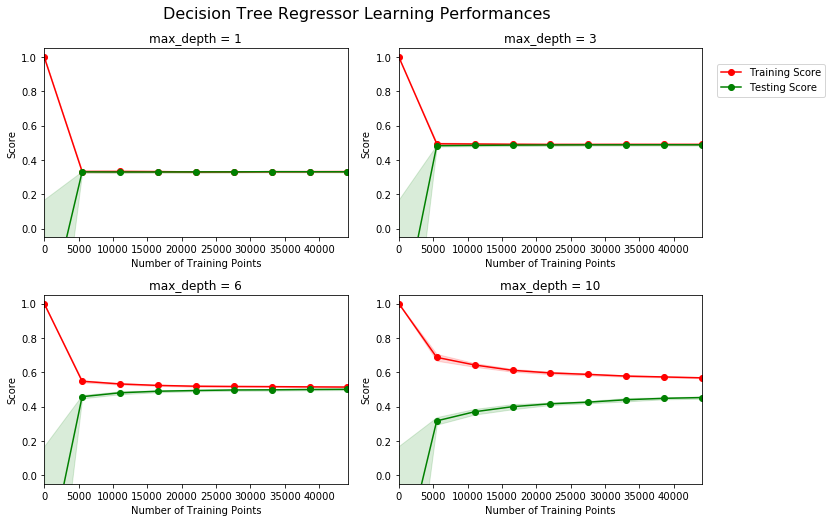

In [36]:
vs.ModelLearning(features_final_notrans, fantasy_notrans)

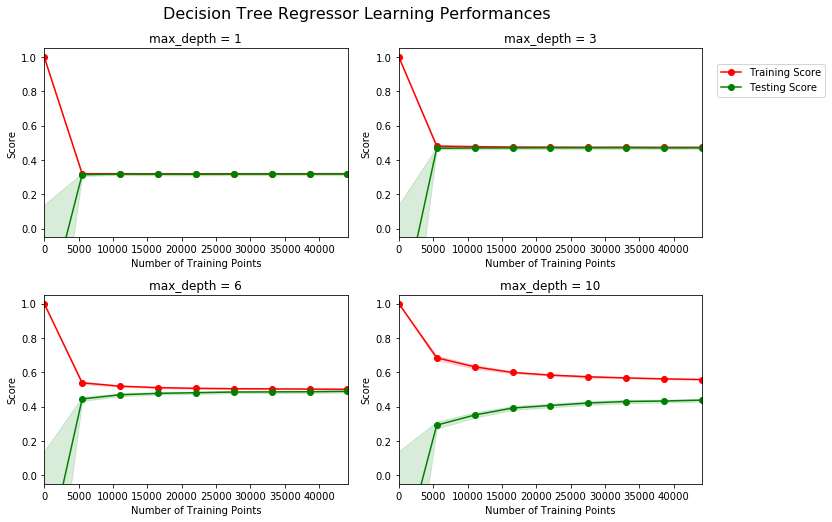

In [37]:
vs.ModelLearning(features_final_notrans, fantasy_trans1)

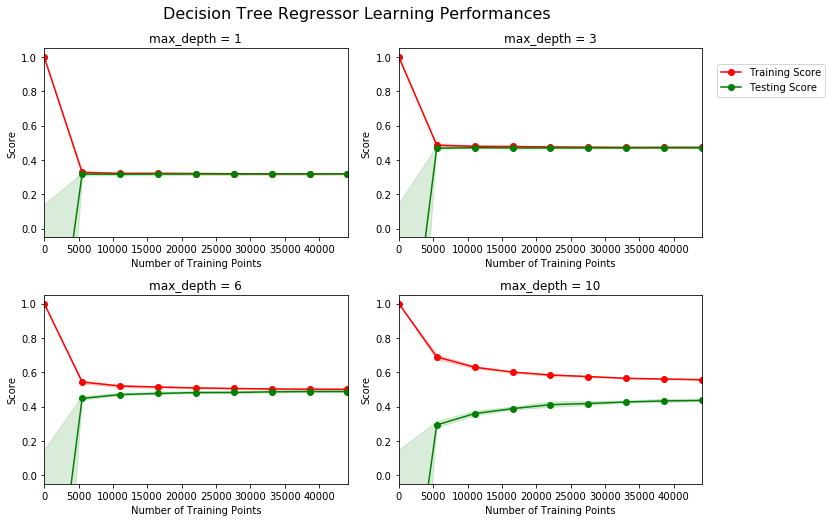

In [38]:
vs.ModelLearning(features_final_trans, fantasy_trans2)

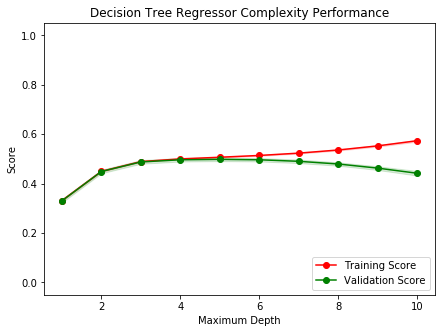

In [39]:
vs.ModelComplexity(X_train1, y_train1)

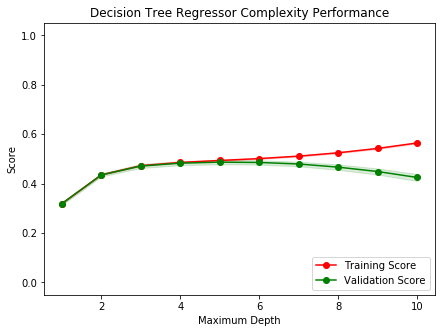

In [40]:
vs.ModelComplexity(X_train2, y_train2)

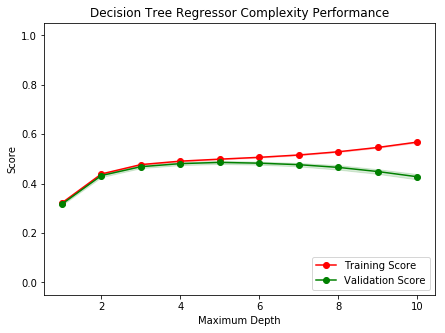

In [41]:
vs.ModelComplexity(X_train3, y_train3)

In [42]:
from sklearn.metrics import make_scorer
from sklearn.cross_validation import ShuffleSplit
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import linear_model, grid_search, neural_network
from time import time

def fit_Tree_model(X, y):
    """ Performs grid search over the 'max_depth' parameter for a 
        decision tree regressor trained on the input data [X, y]. """
    start = time()
    
    # Create cross-validation sets from the training data
    cv_sets = ShuffleSplit(X.shape[0], n_iter = 10, test_size = 0.20, random_state =42)

    regressor = DecisionTreeRegressor(random_state=42)

    params = {'max_depth':range(1,11)}

    scoring_fnc = make_scorer(performance_metric_r2)

    grid = grid_search.GridSearchCV(regressor, params, cv=cv_sets, scoring=scoring_fnc)

    # Fit the grid search object to the data to compute the optimal model
    grid = grid.fit(X, y)
    end=time()
    
    # Print the results
    print "Grid search took {:.4f} seconds".format(end - start)

    # Return the optimal model after fitting the data
    return grid.best_estimator_

def fit_SGD_model(X, y):
    """ Performs grid search over the 'loss' parameter for a 
        SGD regressor trained on the input data [X, y]. """
    start=time()
    
    # Create cross-validation sets from the training data
    cv_sets = ShuffleSplit(X.shape[0], n_iter = 10, test_size = 0.20, random_state =42)

    regressor = linear_model.SGDRegressor(random_state=42)

    params = {'loss':('squared_loss', 'huber', 'epsilon_insensitive')}

    scoring_fnc = make_scorer(performance_metric_r2)

    grid = grid_search.GridSearchCV(regressor, params, cv=cv_sets, scoring=scoring_fnc)

    # Fit the grid search object to the data to compute the optimal model
    grid = grid.fit(X, y)
    end=time()
    
    # Print the results
    print "Grid search took {:.4f} seconds".format(end - start)


    # Return the optimal model after fitting the data
    return grid.best_estimator_

def fit_Boosting_model(X,y):
    """ Performs grid search over the 'max_depth', 'loss', 'learning_rate' and 'n_estimators' parameter for a 
        decision tree regressor trained on the input data [X, y]. """
    start=time()
    # Create cross-validation sets from the training data
    cv_sets = ShuffleSplit(X.shape[0], n_iter = 10, test_size = 0.20, random_state =42)

    regressor = GradientBoostingRegressor(random_state=42)

    params = {'max_depth':range(1,6)}

    scoring_fnc = make_scorer(performance_metric_r2)

    grid = grid_search.GridSearchCV(regressor, params, cv=cv_sets, scoring=scoring_fnc)

    # Fit the grid search object to the data to compute the optimal model
    grid = grid.fit(X, y)
    end=time()
    
    # Print the results
    print "Grid search took {:.4f} seconds".format(end - start)

    # Return the optimal model after fitting the data
    return grid.best_estimator_

def fit_MLP_model(X,y):
    """ Performs grid search over the 'activation' and 'learning_rate' parameters for a 
        MLP regressor trained on the input data [X, y]. """
    start=time()
    # Create cross-validation sets from the training data
    cv_sets = ShuffleSplit(X.shape[0], n_iter = 10, test_size = 0.20, random_state =42)

    regressor = neural_network.MLPRegressor(random_state=42)

    params = {'activation':('logistic','relu'), 'learning_rate':('constant','invscaling')}

    scoring_fnc = make_scorer(performance_metric_r2)

    grid = grid_search.GridSearchCV(regressor, params, cv=cv_sets, scoring=scoring_fnc)

    # Fit the grid search object to the data to compute the optimal model
    grid = grid.fit(X, y)
    end=time()
    
    # Print the results
    print "Grid search took {:.4f} seconds".format(end - start)

    # Return the optimal model after fitting the data
    return grid.best_estimator_

//anaconda/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [43]:
reg1 = fit_Tree_model(X_train1, y_train1)
reg2 = fit_SGD_model(X_train1, y_train1)
reg3 = fit_Boosting_model(X_train1, y_train1)
reg4 = fit_MLP_model(X_train1, y_train1)

# Produce the values for optimal parameters
print "Parameter 'max_depth' is {} for the optimal model.".format(reg1.get_params()['max_depth'])
print "Parameter 'loss' is {} for the optimal model.".format(reg2.get_params()['loss'])
print "Parameter 'max_depth' is {} for the optimal model.".format(reg3.get_params()['max_depth'])
print "Parameter 'activation' is {} for the optimal model.".format(reg4.get_params()['activation'])
print "Parameter 'learning rate' is {} for the optimal model.".format(reg4.get_params()['learning_rate'])

Grid search took 46.5353 seconds
Grid search took 7.1507 seconds
Grid search took 618.0401 seconds
Grid search took 386.8250 seconds
Parameter 'max_depth' is 5 for the optimal model.
Parameter 'loss' is huber for the optimal model.
Parameter 'max_depth' is 3 for the optimal model.
Parameter 'activation' is relu for the optimal model.
Parameter 'learning rate' is constant for the optimal model.


In [44]:
reg5 = fit_Tree_model(X_train2, y_train2)
reg6 = fit_SGD_model(X_train2, y_train2)
reg7 = fit_Boosting_model(X_train2, y_train2)
reg8 = fit_MLP_model(X_train2, y_train2)

# Produce the values for optimal parameters
print "Parameter 'max_depth' is {} for the optimal model.".format(reg5.get_params()['max_depth'])
print "Parameter 'loss' is {} for the optimal model.".format(reg6.get_params()['loss'])
print "Parameter 'max_depth' is {} for the optimal model.".format(reg7.get_params()['max_depth'])
print "Parameter 'activation' is {} for the optimal model.".format(reg8.get_params()['activation'])
print "Parameter 'learning rate' is {} for the optimal model.".format(reg8.get_params()['learning_rate'])

Grid search took 36.6768 seconds
Grid search took 5.2232 seconds
Grid search took 499.1371 seconds
Grid search took 217.0964 seconds
Parameter 'max_depth' is 5 for the optimal model.
Parameter 'loss' is huber for the optimal model.
Parameter 'max_depth' is 3 for the optimal model.
Parameter 'activation' is logistic for the optimal model.
Parameter 'learning rate' is constant for the optimal model.


In [45]:
reg9 = fit_Tree_model(X_train3, y_train3)
reg10 = fit_SGD_model(X_train3, y_train3)
reg11 = fit_Boosting_model(X_train3, y_train3)
reg12 = fit_MLP_model(X_train3, y_train3)

# Produce the values for optimal parameters
print "Parameter 'max_depth' is {} for the optimal model.".format(reg9.get_params()['max_depth'])
print "Parameter 'loss' is {} for the optimal model.".format(reg10.get_params()['loss'])
print "Parameter 'max_depth' is {} for the optimal model.".format(reg11.get_params()['max_depth'])
print "Parameter 'activation' is {} for the optimal model.".format(reg12.get_params()['activation'])
print "Parameter 'learning rate' is {} for the optimal model.".format(reg12.get_params()['learning_rate'])

Grid search took 37.7804 seconds
Grid search took 5.7499 seconds
Grid search took 510.5068 seconds
Grid search took 190.4756 seconds
Parameter 'max_depth' is 5 for the optimal model.
Parameter 'loss' is huber for the optimal model.
Parameter 'max_depth' is 3 for the optimal model.
Parameter 'activation' is logistic for the optimal model.
Parameter 'learning rate' is constant for the optimal model.


In [46]:
def train_regressor(clf, X_train, y_train):
    ''' Fits a regressor to the training data. '''
    
    # Start the clock, train the classifier, then stop the clock
    start = time()
    clf.fit(X_train, y_train)
    end = time()
    
    # Print the results
    print "Trained model in {:.4f} seconds".format(end - start)

    
def predict_labels(clf, features, target):
    ''' Makes predictions using a fit regressor based on R2 score. '''
    
    # Start the clock, make predictions, then stop the clock
    start = time()
    y_pred = clf.predict(features)
    end = time()
    
    # Print and return results
    print "Made predictions in {:.4f} seconds.".format(end - start)
    return r2_score(target.values, y_pred)


def train_predict(clf, X_train, y_train, X_test, y_test):
    ''' Train and predict using a regressor based on R2 score. '''
    
    # Indicate the regressor and the training set size
    print "Training a {} using a training set size of {}. . .".format(clf.__class__.__name__, len(X_train))
    
    # Train the regressor
    train_regressor(clf, X_train, y_train)
    
    # Print the results of prediction for both training and testing
    print "R2 score for training set: {:.4f}.".format(predict_labels(clf, X_train, y_train))
    print "R2 score for test set: {:.4f}.".format(predict_labels(clf, X_test, y_test))

In [47]:
reg_A = linear_model.SGDRegressor(random_state=42,loss=reg2.get_params()['loss'])
reg_B = GradientBoostingRegressor(random_state=42, max_depth=reg3.get_params()['max_depth'])
reg_C = DecisionTreeRegressor(random_state=42, max_depth=reg1.get_params()['max_depth'])
reg_D = neural_network.MLPRegressor(random_state=42, activation=reg4.get_params()['activation'], learning_rate=reg4.get_params()['learning_rate'])

for reg in [reg_A, reg_B, reg_C, reg_D]:
    train_predict(reg,X_train1, y_train1, X_test1, y_test1)

Training a SGDRegressor using a training set size of 44129. . .
Trained model in 0.1363 seconds
Made predictions in 0.0165 seconds.
R2 score for training set: -0.0730.
Made predictions in 0.0101 seconds.
R2 score for test set: -0.0509.
Training a GradientBoostingRegressor using a training set size of 44129. . .
Trained model in 10.6098 seconds
Made predictions in 0.1860 seconds.
R2 score for training set: 0.5230.
Made predictions in 0.0419 seconds.
R2 score for test set: 0.5177.
Training a DecisionTreeRegressor using a training set size of 44129. . .
Trained model in 0.3788 seconds
Made predictions in 0.0225 seconds.
R2 score for training set: 0.5059.
Made predictions in 0.0036 seconds.
R2 score for test set: 0.5084.
Training a MLPRegressor using a training set size of 44129. . .
Trained model in 4.5876 seconds
Made predictions in 0.1746 seconds.
R2 score for training set: 0.5032.
Made predictions in 0.0379 seconds.
R2 score for test set: 0.5114.


In [48]:
reg_E = linear_model.SGDRegressor(random_state=42,loss=reg6.get_params()['loss'])
reg_F = GradientBoostingRegressor(random_state=42, max_depth=reg7.get_params()['max_depth'])
reg_G = DecisionTreeRegressor(random_state=42, max_depth=reg5.get_params()['max_depth'])
reg_H = neural_network.MLPRegressor(random_state=42, activation=reg8.get_params()['activation'], learning_rate=reg8.get_params()['learning_rate'])

for reg in [reg_E, reg_F, reg_G, reg_H]:
    train_predict(reg,X_train2, y_train2, X_test2, y_test2)

Training a SGDRegressor using a training set size of 44129. . .
Trained model in 0.1689 seconds
Made predictions in 0.0207 seconds.
R2 score for training set: 0.1774.
Made predictions in 0.0072 seconds.
R2 score for test set: 0.1875.
Training a GradientBoostingRegressor using a training set size of 44129. . .
Trained model in 11.5750 seconds
Made predictions in 0.1947 seconds.
R2 score for training set: 0.5108.
Made predictions in 0.0455 seconds.
R2 score for test set: 0.5057.
Training a DecisionTreeRegressor using a training set size of 44129. . .
Trained model in 0.3864 seconds
Made predictions in 0.0155 seconds.
R2 score for training set: 0.4936.
Made predictions in 0.0041 seconds.
R2 score for test set: 0.4932.
Training a MLPRegressor using a training set size of 44129. . .
Trained model in 4.7090 seconds
Made predictions in 0.2910 seconds.
R2 score for training set: 0.4936.
Made predictions in 0.0585 seconds.
R2 score for test set: 0.4986.


In [49]:
reg_I = linear_model.SGDRegressor(random_state=42,loss=reg10.get_params()['loss'])
reg_J = GradientBoostingRegressor(random_state=42, max_depth=reg11.get_params()['max_depth'])
reg_K = DecisionTreeRegressor(random_state=42, max_depth=reg9.get_params()['max_depth'])
reg_L = neural_network.MLPRegressor(random_state=42, activation=reg12.get_params()['activation'], learning_rate=reg12.get_params()['learning_rate'])

for reg in [reg_I, reg_J, reg_K, reg_L]:
    train_predict(reg,X_train3, y_train3, X_test3, y_test3)

Training a SGDRegressor using a training set size of 44124. . .
Trained model in 0.1619 seconds
Made predictions in 0.0151 seconds.
R2 score for training set: 0.1981.
Made predictions in 0.0070 seconds.
R2 score for test set: 0.1872.
Training a GradientBoostingRegressor using a training set size of 44124. . .
Trained model in 10.2961 seconds
Made predictions in 0.1778 seconds.
R2 score for training set: 0.5138.
Made predictions in 0.0414 seconds.
R2 score for test set: 0.4905.
Training a DecisionTreeRegressor using a training set size of 44124. . .
Trained model in 0.3593 seconds
Made predictions in 0.0177 seconds.
R2 score for training set: 0.4970.
Made predictions in 0.0030 seconds.
R2 score for test set: 0.4785.
Training a MLPRegressor using a training set size of 44124. . .
Trained model in 9.0287 seconds
Made predictions in 0.3159 seconds.
R2 score for training set: 0.5000.
Made predictions in 0.0908 seconds.
R2 score for test set: 0.4849.


## Using our model, predict values in 2017

Now we have the best model to test out of sample and see how they fare in predicting fantasy scores from 2017.

In [50]:
new_test_df=pd.DataFrame()
for i in range(0,len(unique_players)):
    player_df=sort_test[sort_test['player']==unique_players[i]]
    add_avg(player_df,"pts",10)
    add_avg(player_df, "fantasy",10)
    add_avg(player_df, "plus_minus",10)
    add_avg(player_df, "ast",10)
    add_avg(player_df, "trb",10)
    add_avg(player_df, "stl",10)
    add_avg(player_df, "blk",10)
    add_avg(player_df, "fga",10)
    add_avg(player_df, "p3p",10)
    add_avg(player_df, "mp",10)
    add_avg(player_df, "pts",3)
    add_avg(player_df, "fantasy",3)
    add_avg(player_df, "plus_minus",3)
    add_avg(player_df, "ast",3)
    add_avg(player_df, "trb",3)
    add_avg(player_df, "stl",3)
    add_avg(player_df, "blk",3)
    add_avg(player_df, "fga",3)
    add_avg(player_df, "p3p",3)
    add_avg(player_df, "mp",3)
    player_df['rest_days']=pd.to_datetime(player_df['game_date'],format=date_format).values-pd.to_datetime(player_df['game_date'],format=date_format).shift(1).values
    player_df['rest']=(player_df['rest_days'].dt.total_seconds() / (24 * 60 * 60)).values
    player_df.loc[player_df['rest']>5,'rest']=5
    new_test_df=new_test_df.append(player_df)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/st

In [51]:
opp_test_data=pd.DataFrame({'opp_sum_fantasy':sort_test.groupby(['opp_team','game_date'])['fantasy'].sum()}).reset_index()
teams_test_df=pd.DataFrame()
for i in range(0,len(unique_teams)):
    team_df=opp_test_data[opp_test_data['opp_team']==unique_teams[i]]
    add_opp(team_df,'opp_sum_fantasy',10)
    teams_test_df=teams_test_df.append(team_df)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [52]:
final_test_data=pd.merge(new_test_df, teams_test_df, on=['opp_team','game_date'], how='left')

In [53]:
#drop the stats I don't need
test_features = final_test_data.drop(['player','game_date','age','player_team','opp_team','result',
                            'gs','mp','fg','fga','fgp','ft','fta','ftp','ast','orb','drb','trb',
                            'stl','blk','p3','p3a','p3p','pts','plus_minus',
                            'game_score','year_end','tov','pf', 'opp_sum_fantasy', 'rest_days'], axis=1)

#remove any Na's
test_features_clean_notrans=test_features.dropna()

#transform the features into normal distributions
test_features['avg10fantasy_trans']=np.power(test_features['avg10fantasy'],0.5)
test_features['avg3fantasy_trans']=np.power(test_features['avg3fantasy'],0.5)
test_features['avg10pts_trans']=np.power(test_features['avg10pts'],0.5)
test_features['avg3pts_trans']=np.power(test_features['avg3pts'],0.5)
test_features['avg10trb_trans']=np.power(test_features['avg10trb'],0.5)
test_features['avg3trb_trans']=np.power(test_features['avg3trb'],0.5)
test_features['avg10ast_trans']=np.power(test_features['avg10ast'],0.5)
test_features['avg3ast_trans']=np.power(test_features['avg3ast'],0.5)
test_features['avg10fga_trans']=np.power(test_features['avg10fga'],0.5)
test_features['avg3fga_trans']=np.power(test_features['avg3fga'],0.5)

#drop the untransformed features
test_features_trans = test_features.drop(['avg10pts','avg3pts','avg10trb','avg3trb','avg10ast','avg3ast', 'avg10fga','avg3fga'], axis=1)

#drop any NA's due to negative or missing data
test_features_clean_trans=test_features_trans.dropna()

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in power


In [54]:
#create variable for dependants and features
test_rolling_3_notrans = test_features_clean_notrans['avg3fantasy']
test_rolling_10_notrans = test_features_clean_notrans['avg10fantasy']
test_rolling_3_trans = test_features_clean_trans['avg3fantasy']
test_rolling_10_trans = test_features_clean_trans['avg10fantasy']

test_fantasy_notrans = test_features_clean_notrans['fantasy']
test_fantasy_trans1 = test_features_clean_notrans['fantasy_trans']
test_fantasy_trans2 = test_features_clean_trans['fantasy_trans']

test_features_clean_notrans.drop(['fantasy','fantasy_trans'],axis=1, inplace=True)
test_features_clean_trans.drop(['fantasy','fantasy_trans','avg3fantasy','avg10fantasy'],axis=1, inplace=True)
test_features_clean_notrans.replace(['H','A'],[1,0], inplace=True)
test_features_clean_trans.replace(['H','A'],[1,0], inplace=True)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the ca

## Let's predict the out of sample data with our best model

In [55]:
#the best model was the boosting regression with no transformations
preds=reg3.predict(test_features_clean_notrans)

In [56]:
print("The R2 for the best model regression: " + str(r2_score(test_fantasy_notrans, preds)))

The R2 for the best model regression: 0.577630097655


In [57]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

print("The MSE for the best model regression: " + str(mean_squared_error(preds, test_fantasy_notrans)))
print("The MAE for the best model regression: " + str(mean_absolute_error(preds, test_fantasy_notrans)))

The MSE for the best model regression: 84.0400322641
The MAE for the best model regression: 7.24858846945


In [58]:
print("The number of predictions: " + str(len(test_fantasy_notrans)))

The number of predictions: 10346


## To see if the model is useful, let's compare to a naive prediction of the 10 and 3 game average fantasy scores

In [59]:
print("Here is what I am trying to beat:")
print("\n")
print("The MSE for all players, using past 10 game fantasy average: " + str(mean_squared_error(test_rolling_10_notrans, test_fantasy_notrans)))
print("The MSE for all players, using the past 3 game fantasy average: " + str(mean_squared_error(test_rolling_3_notrans, test_fantasy_notrans)))
print("\n")
print("The MAE for all players, using past 10 game fantasy average: " + str(mean_absolute_error(test_rolling_10_notrans, test_fantasy_notrans)))
print("The MAE for all players, using the past 3 game fantasy average: " + str(mean_absolute_error(test_rolling_3_notrans, test_fantasy_notrans)))
print("\n")

print("Here is how our model performed:")
print("The MSE for the best model regression: " + str(mean_squared_error(preds, test_fantasy_notrans)))
print("The MAE for the best model regression: " + str(mean_absolute_error(preds, test_fantasy_notrans)))

Here is what I am trying to beat:


The MSE for all players, using past 10 game fantasy average: 85.4280515417
The MSE for all players, using the past 3 game fantasy average: 99.9025931922


The MAE for all players, using past 10 game fantasy average: 7.22817514015
The MAE for all players, using the past 3 game fantasy average: 7.78359591469


Here is how our model performed:
The MSE for the best model regression: 84.0400322641
The MAE for the best model regression: 7.24858846945


In [74]:
#create a function to create a boosting regression by player
def player_reg(player_name, train_data, test_data):
    #get data for a single player
    player_data=train_data[train_data['player']==player_name]
    #drop the features I don't need
    player_features=player_data.drop(['player','game_date','age','player_team','opp_team','result',
                            'gs','mp','fg','fga','fgp','ft','fta','ftp','ast','orb','drb','trb',
                            'stl','blk','p3','p3a','p3p','pts','plus_minus',
                            'game_score','year_end','tov','pf', 'opp_sum_fantasy', 'rest_days'], axis=1)
    
    player_features_clean_notrans=player_features.dropna()
    # do the transformation on the features
    player_features['avg10fantasy_trans']=np.power(player_features['avg10fantasy'],0.5)
    player_features['avg3fantasy_trans']=np.power(player_features['avg3fantasy'],0.5)
    player_features['avg10pts_trans']=np.power(player_features['avg10pts'],0.5)
    player_features['avg3pts_trans']=np.power(player_features['avg3pts'],0.5)
    player_features['avg10trb_trans']=np.power(player_features['avg10trb'],0.5)
    player_features['avg3trb_trans']=np.power(player_features['avg3trb'],0.5)
    player_features['avg10ast_trans']=np.power(player_features['avg10ast'],0.5)
    player_features['avg3ast_trans']=np.power(player_features['avg3ast'],0.5)
    player_features['avg10fga_trans']=np.power(player_features['avg10fga'],0.5)
    player_features['avg3fga_tans']=np.power(player_features['avg3fga'],0.5)
    #drop the untransformed data
    player_features_trans = player_features.drop(['avg10fantasy','avg3fantasy', 'avg10pts','avg3pts','avg10trb','avg3trb','avg10ast','avg3ast','avg10fga','avg3fga'], axis=1)
    #drop any NA's
    player_features_clean_trans = player_features_trans.dropna()
    #create new dataframes
    player_fantasy_notrans=player_features_clean_notrans['fantasy']
    player_fantasy_trans1=player_features_clean_notrans['fantasy_trans']
    player_fantasy_trans2=player_features_clean_trans['fantasy_trans']
    player_features_clean_trans.drop(['fantasy','fantasy_trans'],axis=1,inplace=True)
    player_features_clean_notrans.drop(['fantasy','fantasy_trans'],axis=1,inplace=True)
    player_features_clean_trans.replace(['H','A'],[1,0], inplace=True)
    player_features_clean_notrans.replace(['H','A'],[1,0], inplace=True)
    
    X_train1, X_test1, y_train1, y_test1 = cross_validation.train_test_split(
    player_features_clean_notrans, player_fantasy_notrans, test_size=0.2, random_state=42)
    
    player_reg_model=fit_Boosting_model(X_train1, y_train1)
    
    reg_A = GradientBoostingRegressor(random_state=42,max_depth=player_reg_model.get_params()['max_depth'])
    
    train_predict(reg_A,X_train1, y_train1, X_test1, y_test1)
        
    player_data_test=test_data[test_data['player']==player_name]
    player_features_test=player_data_test.drop(['player','game_date','age','player_team','opp_team','result',
                            'gs','mp','fg','fga','fgp','ft','fta','ftp','ast','orb','drb','trb',
                            'stl','blk','p3','p3a','p3p','pts','plus_minus',
                            'game_score','year_end','tov','pf', 'opp_sum_fantasy', 'rest_days'], axis=1)

    player_features_clean_test_notrans=player_features_test.dropna()
    #create new dataframes
    player_rolling_3_test_notrans = player_features_clean_test_notrans['avg3fantasy']
    player_rolling_10_test_notrans = player_features_clean_test_notrans['avg10fantasy']
    player_fantasy_test_notrans=player_features_clean_test_notrans['fantasy']
    player_features_clean_test_notrans.drop(['fantasy','fantasy_trans'],axis=1,inplace=True)
    player_features_clean_test_notrans.replace(['H','A'],[1,0], inplace=True)
    
    preds=player_reg_model.predict(player_features_clean_test_notrans)
    
    print("The MSE for the boosting regression: " + str(mean_squared_error(preds, player_fantasy_test_notrans)))
    print("The MSE for this player, using past 10 game fantasy average: " + str(mean_squared_error(player_rolling_10_test_notrans, player_fantasy_test_notrans)))
    print("The MSE for this player, using the past 3 game fantasy average: " + str(mean_squared_error(player_rolling_3_test_notrans, player_fantasy_test_notrans)))
    ten_game_mse=mean_squared_error(player_rolling_10_test_notrans, player_fantasy_test_notrans)
    three_game_mse=mean_squared_error(player_rolling_3_test_notrans, player_fantasy_test_notrans)
    player_mse = mean_squared_error(player_reg_model.predict(player_features_clean_test_notrans), player_fantasy_test_notrans)
    
    return_dict={player_name:{'model':player_reg_model, 'model mse':player_mse, 'avg 10 mse':ten_game_mse, 'avg 3 mse':three_game_mse}}
    return return_dict

In [92]:
#create a function to test the boosting regression trained on all players for a selecty group of players
def player_model_select(player_name, train_data, test_data, best_model):
    player_reg_model=best_model
        
    player_data_test=test_data[test_data['player']==player_name]
    player_features_test=player_data_test.drop(['player','game_date','age','player_team','opp_team','result',
                            'gs','mp','fg','fga','fgp','ft','fta','ftp','ast','orb','drb','trb',
                            'stl','blk','p3','p3a','p3p','pts','plus_minus',
                            'game_score','year_end','tov','pf', 'opp_sum_fantasy', 'rest_days'], axis=1)

    player_features_clean_test_notrans=player_features_test.dropna()
    #create new dataframes
    player_rolling_3_test_notrans = player_features_clean_test_notrans['avg3fantasy']
    player_rolling_10_test_notrans = player_features_clean_test_notrans['avg10fantasy']
    player_fantasy_test_notrans=player_features_clean_test_notrans['fantasy']
    player_features_clean_test_notrans.drop(['fantasy','fantasy_trans'],axis=1,inplace=True)
    player_features_clean_test_notrans.replace(['H','A'],[1,0], inplace=True)
    
    preds=player_reg_model.predict(player_features_clean_test_notrans)
    
    print("The MSE for the boosting regression: " + str(mean_squared_error(preds, player_fantasy_test_notrans)))
    print("The MSE for this player, using past 10 game fantasy average: " + str(mean_squared_error(player_rolling_10_test_notrans, player_fantasy_test_notrans)))
    print("The MSE for this player, using the past 3 game fantasy average: " + str(mean_squared_error(player_rolling_3_test_notrans, player_fantasy_test_notrans)))
    ten_game_mse=mean_squared_error(player_rolling_10_test_notrans, player_fantasy_test_notrans)
    three_game_mse=mean_squared_error(player_rolling_3_test_notrans, player_fantasy_test_notrans)
    player_mse = mean_squared_error(player_reg_model.predict(player_features_clean_test_notrans), player_fantasy_test_notrans)
    
    return_dict={player_name:{'model':player_reg_model, 'model mse':player_mse, 'avg 10 mse':ten_game_mse, 'avg 3 mse':three_game_mse}}
    return return_dict

In [105]:
#create the top 50 and 100 players by fantasy score
top_200=[]
for i in sort_train.player.unique():
    top_200.append([str(i), np.mean(sort_train[sort_train['player']==i]['fantasy'])])

top_200_fantasy=sorted(top_200, key=lambda x: (x[1]), reverse=True)

cnt=1
top_50_final=[]
for i in top_200_fantasy:
    if cnt < 51:
        top_50_final.append(i)
    cnt += 1

cnt=1
top_100_final=[]
for j in top_200_fantasy:
    if cnt<101:
        top_100_final.append(j)
    cnt+=1

In [ ]:
#create a dictionary of the regression results for the top 50 players using a boosting regression trained by player
player_dict={}
for i in top_50_final:
    player_dict.update(player_reg(i[0], final_data, final_test_data))

In [116]:
#create a dictionary of the boosting regression trained on all players for the top 50 players
player_dict_50={}
for i in top_50_final:
    player_dict_50.update(player_model_select(i[0], final_data, final_test_data,reg3))

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


The MSE for the boosting regression: 184.898365462
The MSE for this player, using past 10 game fantasy average: 163.097152778
The MSE for this player, using the past 3 game fantasy average: 222.124614198
The MSE for the boosting regression: 117.139492674
The MSE for this player, using past 10 game fantasy average: 118.273854167
The MSE for this player, using the past 3 game fantasy average: 145.153549383
The MSE for the boosting regression: 171.833896422
The MSE for this player, using past 10 game fantasy average: 181.225753676
The MSE for this player, using the past 3 game fantasy average: 188.118872549
The MSE for the boosting regression: 198.683153756
The MSE for this player, using past 10 game fantasy average: 153.171714744
The MSE for this player, using the past 3 game fantasy average: 232.098468661
The MSE for the boosting regression: 64.9148612756
The MSE for this player, using past 10 game fantasy average: 59.8030729167
The MSE for this player, using the past 3 game fantasy ave

In [117]:
#create a dictionary of the boosting regression trained on all players for the top 100 players
player_dict_100={}
for i in top_100_final:
    player_dict_100.update(player_model_select(i[0], final_data, final_test_data,reg3))

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


The MSE for the boosting regression: 184.898365462
The MSE for this player, using past 10 game fantasy average: 163.097152778
The MSE for this player, using the past 3 game fantasy average: 222.124614198
The MSE for the boosting regression: 117.139492674
The MSE for this player, using past 10 game fantasy average: 118.273854167
The MSE for this player, using the past 3 game fantasy average: 145.153549383
The MSE for the boosting regression: 171.833896422
The MSE for this player, using past 10 game fantasy average: 181.225753676
The MSE for this player, using the past 3 game fantasy average: 188.118872549
The MSE for the boosting regression: 198.683153756
The MSE for this player, using past 10 game fantasy average: 153.171714744
The MSE for this player, using the past 3 game fantasy average: 232.098468661
The MSE for the boosting regression: 64.9148612756
The MSE for this player, using past 10 game fantasy average: 59.8030729167
The MSE for this player, using the past 3 game fantasy ave

In [118]:
total_fantasy=0
for i in top_50_final:
    total_fantasy += i[1]

total_fantasy_50=0
for i in top_50_final:
    total_fantasy_50 += i[1]
    
total_fantasy_100=0
for i in top_100_final:
    total_fantasy_100 += i[1]

In [119]:
reg_mse=0
avg10_mse=0
avg3_mse=0
for i in top_50_final:
    reg_mse += player_dict[i[0]]['model mse']*i[1]/total_fantasy
    avg10_mse += player_dict[i[0]]['avg 10 mse']*i[1]/total_fantasy
    avg3_mse += player_dict[i[0]]['avg 3 mse']*i[1]/total_fantasy
    
reg_mse_50=0
avg10_mse_50=0
avg3_mse_50=0
for i in top_50_final:
    reg_mse_50 += player_dict_50[i[0]]['model mse']*i[1]/total_fantasy_50
    avg10_mse_50 += player_dict_50[i[0]]['avg 10 mse']*i[1]/total_fantasy_50
    avg3_mse_50 += player_dict_50[i[0]]['avg 3 mse']*i[1]/total_fantasy_50
    
reg_mse_100=0
avg10_mse_100=0
avg3_mse_100=0
for i in top_100_final:
    reg_mse_100 += player_dict_100[i[0]]['model mse']*i[1]/total_fantasy_100
    avg10_mse_100 += player_dict_100[i[0]]['avg 10 mse']*i[1]/total_fantasy_100
    avg3_mse_100 += player_dict_100[i[0]]['avg 3 mse']*i[1]/total_fantasy_100

## How well does the Boosting regression work out of sample? For the top players, is the model better to be trained by player or on all players?

In [120]:
print(reg_mse)
print(avg3_mse)
print(avg10_mse)
print("\n")
print(reg_mse_50)
print(avg3_mse_50)
print(avg10_mse_50)
print("\n")
print(reg_mse_100)
print(avg3_mse_100)
print(avg10_mse_100)


197.972113014
153.634886477
127.660372789


128.047080358
153.634886477
127.660372789


116.830235742
140.711518353
117.827193147


In [127]:
print("MSE from Boosting regression by player for top 50 players: " + str(sum(player_dict[key]['model mse'] for key, value in player_dict.items())/50))
print("MSE from rolling 3-day average fantasy for top 50 players: " + str(sum(player_dict[key]['avg 3 mse'] for key, value in player_dict.items())/50))
print("MSE from rolling 10-day average fantasy for top 50 players: " + str(sum(player_dict[key]['avg 10 mse'] for key, value in player_dict.items())/50))
print("\n")
print("MSE from Boosting regression of all players for top 50 players: " + str(sum(player_dict_50[key]['model mse'] for key, value in player_dict_50.items())/50))
print("MSE from rolling 3-day average fantasy for top 50 players: " + str(sum(player_dict_50[key]['avg 3 mse'] for key, value in player_dict_50.items())/50))
print("MSE from rolling 10-day average fantasy for top 50 players: " + str(sum(player_dict_50[key]['avg 10 mse'] for key, value in player_dict_50.items())/50))
print("\n")
print("MSE from Boosting regression of all players for top 100 players: " + str(sum(player_dict_100[key]['model mse'] for key, value in player_dict_100.items())/100))
print("MSE from rolling 3-day average fantasy for top 100 players: " + str(sum(player_dict_100[key]['avg 3 mse'] for key, value in player_dict_100.items())/100))
print("MSE from rolling 10-day average fantasy for top 100 players: " + str(sum(player_dict_100[key]['avg 10 mse'] for key, value in player_dict_100.items())/100))
print("\n")

MSE from Boosting regression by player for top 50 players: 200.1020366
MSE from rolling 3-day average fantasy for top 50 players: 150.489530825
MSE from rolling 10-day average fantasy for top 50 players: 125.595451105


MSE from Boosting regression of all players for top 50 players: 125.297913119
MSE from rolling 3-day average fantasy for top 50 players: 150.489530825
MSE from rolling 10-day average fantasy for top 50 players: 125.595451105


MSE from Boosting regression of all players for top 100 players: 113.191828559
MSE from rolling 3-day average fantasy for top 100 players: 136.504801715
MSE from rolling 10-day average fantasy for top 100 players: 114.706099684




## Let's take a look at the MSE by player

In [ ]:
player_dict

In [123]:
player_dict_50

{'Al Horford': {'avg 10 mse': 62.773880208333345,
  'avg 3 mse': 90.082754629629633,
  'model': GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
               learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
               max_leaf_nodes=None, min_impurity_split=1e-07,
               min_samples_leaf=1, min_samples_split=2,
               min_weight_fraction_leaf=0.0, n_estimators=100,
               presort='auto', random_state=42, subsample=1.0, verbose=0,
               warm_start=False),
  'model mse': 58.076034579786871},
 'Al Jefferson': {'avg 10 mse': 64.519785714285717,
  'avg 3 mse': 78.881746031746033,
  'model': GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
               learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
               max_leaf_nodes=None, min_impurity_split=1e-07,
               min_samples_leaf=1, min_samples_split=2,
               min_weight_fraction_leaf=0.0, n_estimators=100

In [124]:
player_dict_100

{'Al Horford': {'avg 10 mse': 62.773880208333345,
  'avg 3 mse': 90.082754629629633,
  'model': GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
               learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
               max_leaf_nodes=None, min_impurity_split=1e-07,
               min_samples_leaf=1, min_samples_split=2,
               min_weight_fraction_leaf=0.0, n_estimators=100,
               presort='auto', random_state=42, subsample=1.0, verbose=0,
               warm_start=False),
  'model mse': 58.076034579786871},
 'Al Jefferson': {'avg 10 mse': 64.519785714285717,
  'avg 3 mse': 78.881746031746033,
  'model': GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
               learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
               max_leaf_nodes=None, min_impurity_split=1e-07,
               min_samples_leaf=1, min_samples_split=2,
               min_weight_fraction_leaf=0.0, n_estimators=100

## Let's look at the model in more detail

In [138]:
cnt = 0
for i in test_features_clean_notrans.columns:
    print(i + ": " + str(reg3.feature_importances_[cnt]))
    cnt += 1

location: 0.0212089012565
avg10pts: 0.0301846769599
avg10fantasy: 0.168544731288
avg10plus_minus: 0.030037108921
avg10ast: 0.0392926238958
avg10trb: 0.0382879450551
avg10stl: 0.0237614780141
avg10blk: 0.0260863838387
avg10fga: 0.0429977724883
avg10p3p: 0.0688539786043
avg10mp: 0.0509332983104
avg3pts: 0.00650061868749
avg3fantasy: 0.0956311571584
avg3plus_minus: 0.046454873267
avg3ast: 0.0167980026908
avg3trb: 0.0296512946353
avg3stl: 0.0099673014451
avg3blk: 0.00721621488957
avg3fga: 0.0716017799122
avg3p3p: 0.0201170567098
avg3mp: 0.0684214150467
rest: 0.0281471654469
avg 10opp_sum_fantasy: 0.0593042214782
